In [ ]:
import tensorflow as tf
 
# Display the version
print(tf.__version__)    

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Add, ReLU
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

2.12.0


In [ ]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10
 
# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU: ',tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
 
# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
'''
Opción 1:
tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=avg,
    classes=10,
    classifier_activation='softmax'
)

https://keras.io/api/applications/resnet/
'''

'\nOpción 1:\ntf.keras.applications.ResNet50(\n    include_top=True,\n    weights="imagenet",\n    input_tensor=None,\n    input_shape=None,\n    pooling=avg,\n    classes=10,\n    classifier_activation=\'softmax\'\n)\n\nhttps://keras.io/api/applications/resnet/\n'

In [ ]:
def identity_block(inp, filters: int):
    # Corresponde a los bloque normales, donde solo hay stripe=(1,1)
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding="same",kernel_initializer='he_normal')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding="same",kernel_initializer='he_normal')(inp)
    x = BatchNormalization()(x)
    x = Add()([inp,x])
    x = Activation('relu')(x)
    return x

def conv_block(inp, filters: int):
    # Corresponde al primer bloque de cada grupo, el cual tiene stripe=(2,2)
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(2,2), padding="same",kernel_initializer='he_normal')(inp)
    x = BatchNormalization()(x)
    shortcut = Activation('relu')(x)

    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding="same",kernel_initializer='he_normal')(shortcut)
    x = BatchNormalization()(x)
    x = Add()([shortcut,x])
    x = Activation('relu')(x)
    return x

In [ ]:
i = Input(shape=x_train[0].shape)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',kernel_initializer='he_normal')(i) # Originalmente ks=(7,7), stride=(2,2), f=64
x = Activation('relu')(x)

x = identity_block(x, 64)
x = identity_block(x, 64)
x = identity_block(x, 64)

x = conv_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)


x = conv_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)

x = conv_block(x, 512)
x = identity_block(x, 512)
x = identity_block(x, 512)

x = AveragePooling2D((2,2))(x) # Alterar esta para encajar en nuestro input
x = Flatten()(x)
x = Dense(10, activation='softmax')(x) # Originalmente es 1000, pero para cifar10 dee ser 10

model = Model(i, x)
 
# model description
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 activation_33 (Activation)     (None, 32, 32, 64)   0           ['conv2d_33[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 32, 32, 64)   36928       ['activation_33[0][0]']          
                                                                                            

In [ ]:
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit
r = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20)

Epoch 1/20
1563/1563 [==============================] - 86s 46ms/step - loss: 0.0759 - accuracy: 0.9734 - val_loss: 0.7595 - val_accuracy: 0.8214
Epoch 2/20
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0592 - accuracy: 0.9798 - val_loss: 0.9825 - val_accuracy: 0.8108
Epoch 3/20
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0548 - accuracy: 0.9811 - val_loss: 0.8823 - val_accuracy: 0.8129
Epoch 4/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.8136 - val_accuracy: 0.8301
Epoch 5/20
1563/1563 [==============================] - 70s 44ms/step - loss: 0.0426 - accuracy: 0.9847 - val_loss: 1.1044 - val_accuracy: 0.8049
Epoch 6/20
1563/1563 [==============================] - 68s 44ms/step - loss: 0.0384 - accuracy: 0.9871 - val_loss: 0.9028 - val_accuracy: 0.8206
Epoch 7/20
1563/1563 [==============================] - 69s 44ms/step - loss: 0.0358 - accuracy: 0.9874 - val_loss: 0.9083 -

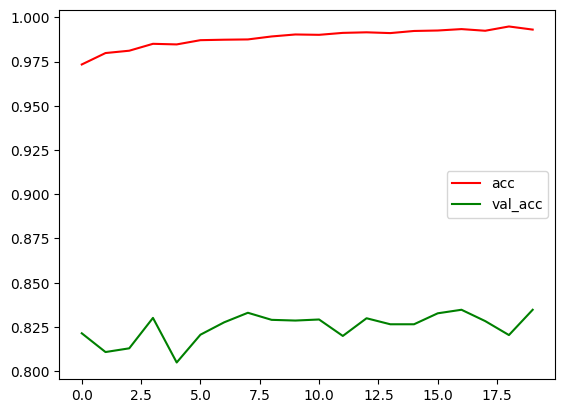

In [ ]:
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [ ]:
# Matriz de confusión

y_pred = model.predict(x_test)
newy_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
  newy_pred[i] = int(np.argmax(y_pred[i]))

313/313 [==============================] - 4s 11ms/step


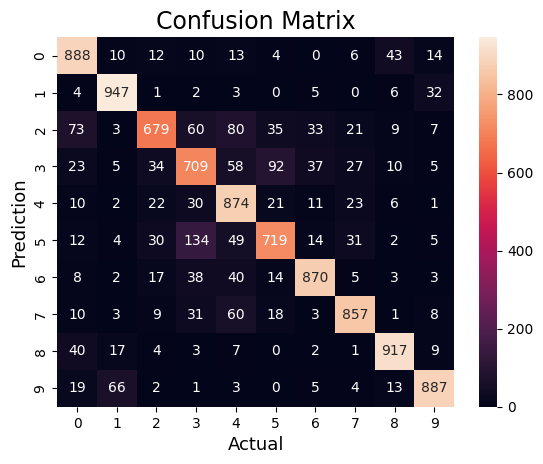

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, newy_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()